# Data Cleaning and Exploration

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Read in the data and display the head.

In [2]:
url_data = pd.read_csv('train_dataset.csv')
url_data.head()

,url,label,source,url_has_login,url_has_client,url_has_server,url_has_admin,url_has_ip,url_isshorted,url_len,...,pdomain_count_hyphen,pdomain_count_atrate,pdomain_count_non_alphanum,pdomain_count_digit,tld_len,tld,tld_is_sus,pdomain_min_distance,subdomain_len,subdomain_count_dot
0,irs-profilepaymentservice.com/home,1,phishtank,0,0,0,0,0,0,34,...,0,0,0,0,3,com,0,17,0,0
1,cpuggsukabumi.id,0,majestic_million,0,0,0,0,0,0,16,...,0,0,0,0,2,id,1,10,0,0
2,members.tripod.com/~don_rc/ring.htm,0,data_clean_test_mendel,0,0,0,0,0,0,35,...,0,0,0,0,3,com,0,2,7,0
3,optuswebmailadminprovider.weebly.com/,1,phishtank,0,0,0,1,0,0,37,...,0,0,0,0,3,com,0,3,25,0
4,topoz.com.pl,0,dmoz_harvard,0,0,0,0,0,0,12,...,0,0,0,0,6,com.pl,0,3,0,0


#### Check the dataset for missing values.

There are none! :D

In [3]:
url_data.isnull().sum()

url                                    0
label                                  0
source                                 0
url_has_login                          0
url_has_client                         0
url_has_server                         0
url_has_admin                          0
url_has_ip                             0
url_isshorted                          0
url_len                                0
url_entropy                            0
url_hamming_1                          0
url_hamming_00                         0
url_hamming_10                         0
url_hamming_01                         0
url_hamming_11                         0
url_2bentropy                          0
url_3bentropy                          0
url_count_dot                          0
url_count_https                        0
url_count_http                         0
url_count_perc                         0
url_count_hyphen                       0
url_count_www                          0
url_count_atrate

#### Check for a class imbalance.

There are 1445673 malicious URLS (label = 1) and 5283175 benign URLS (label = 0). 27.36% of the data are positive. 
Because the cost of a false negative is greater than the cost of a false positive, clicking on a malicious URL for the former and not clicking on a benign URL for the latter, we will prioritize detection of malicious URLs. Thus, inside of the cross validation loop, we will employ oversampling of the minority class.

In [4]:
url_data['label'].value_counts()

label
0    5283175
1    1445673
Name: count, dtype: int64

#### Visualize the feature values.
Plot all of the numerical features as a histogram.

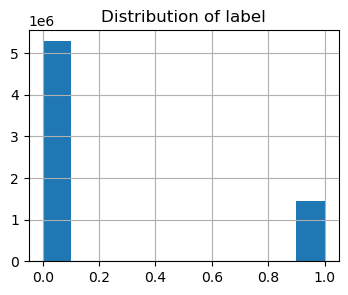

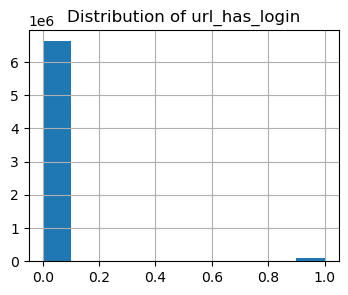

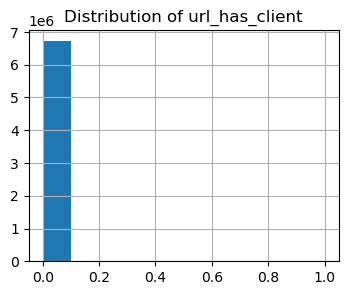

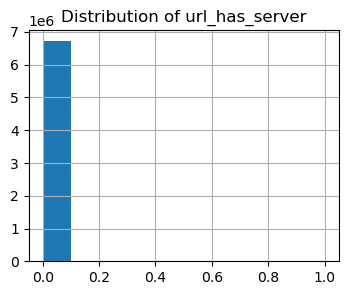

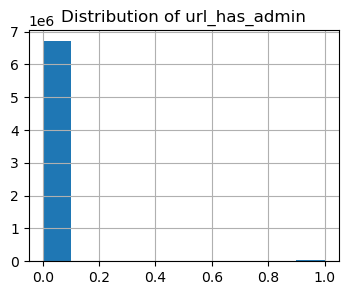

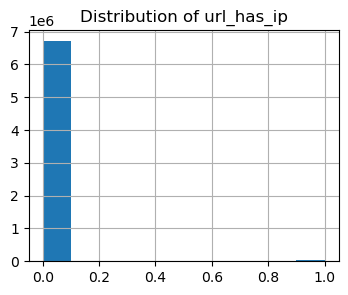

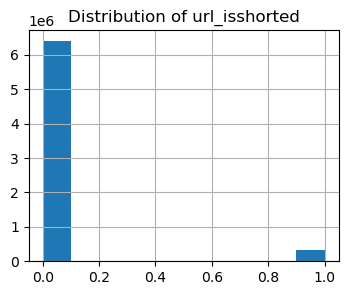

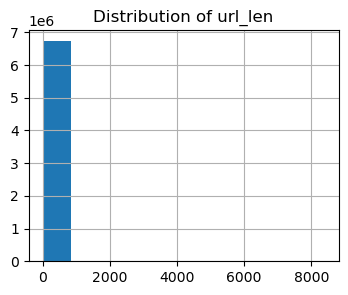

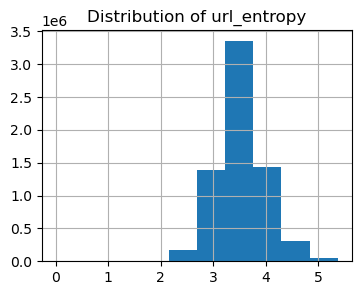

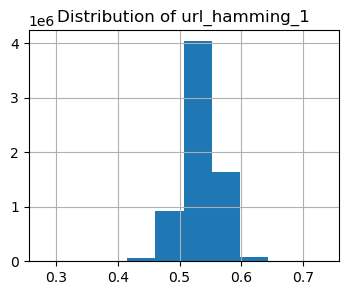

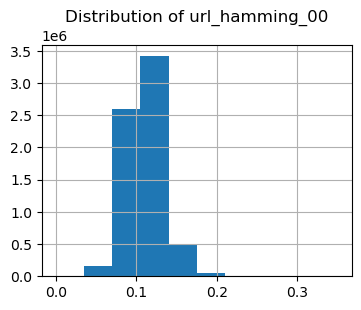

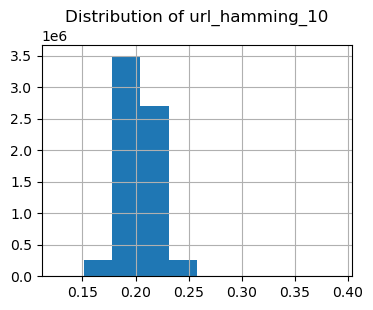

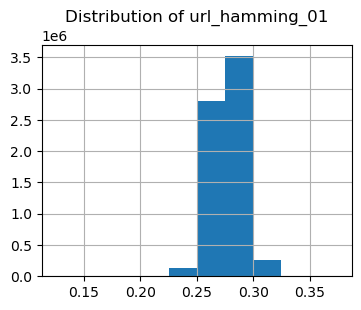

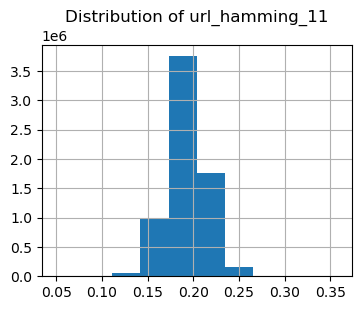

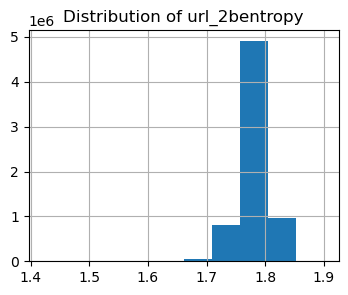

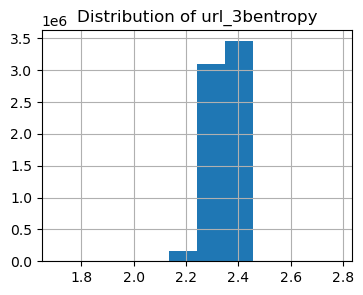

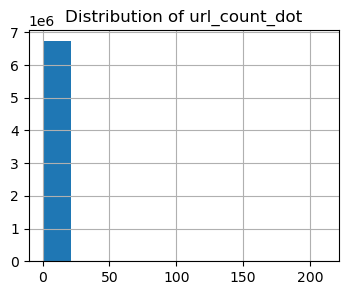

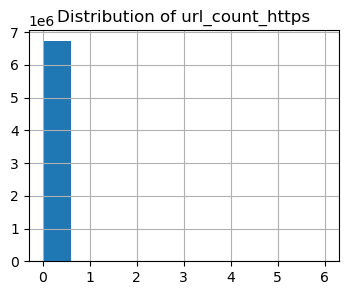

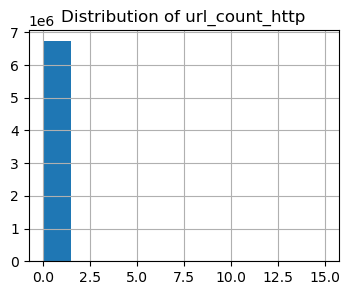

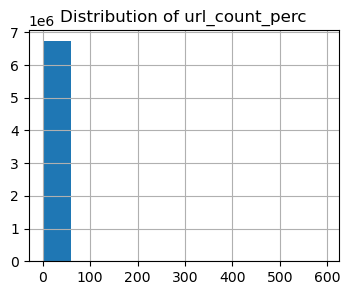

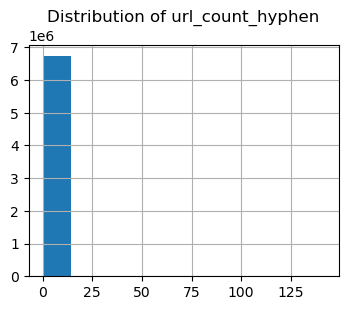

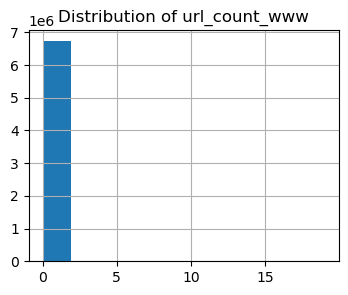

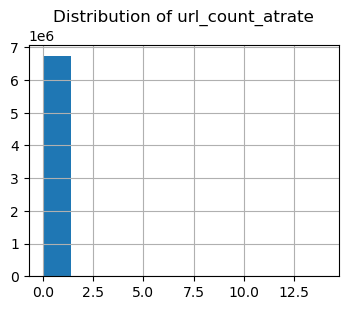

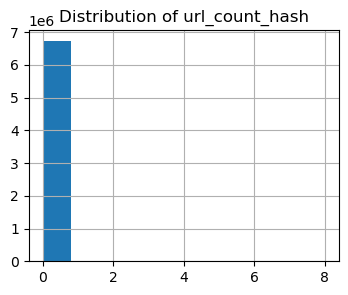

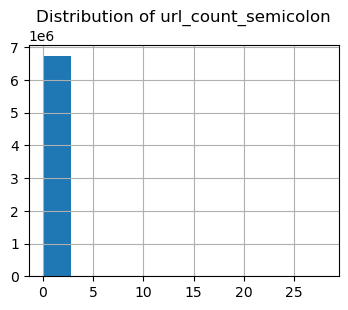

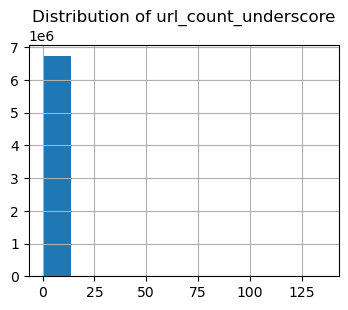

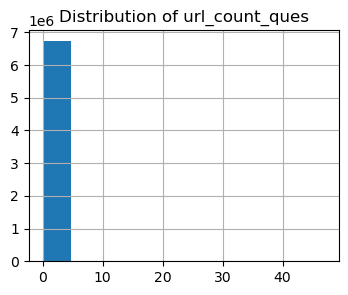

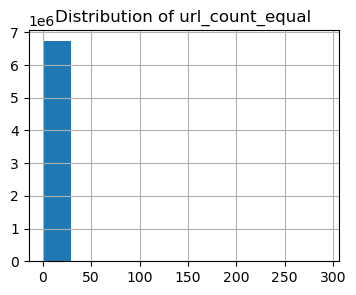

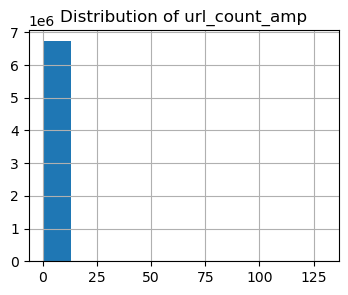

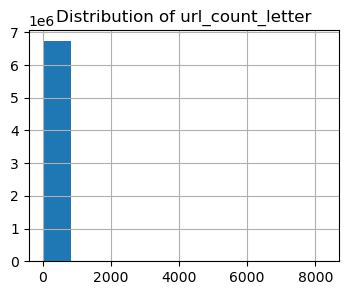

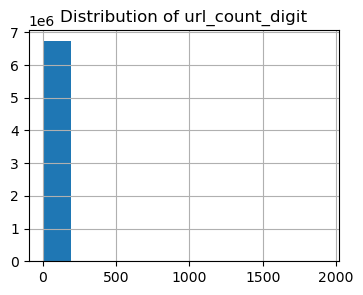

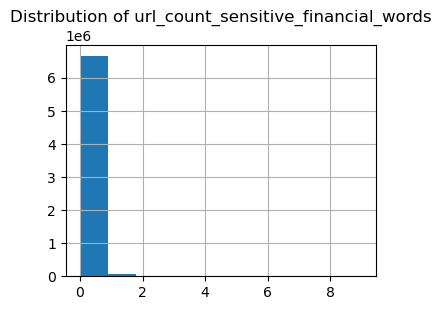

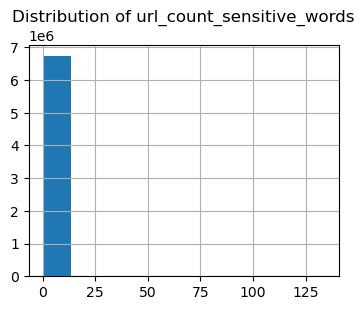

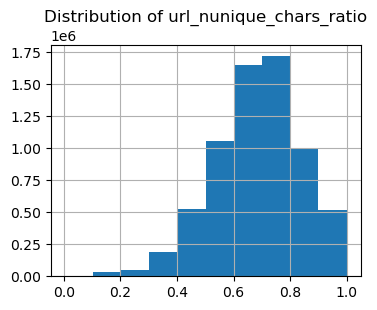

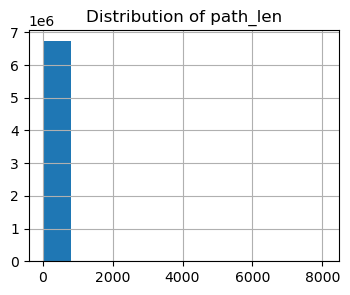

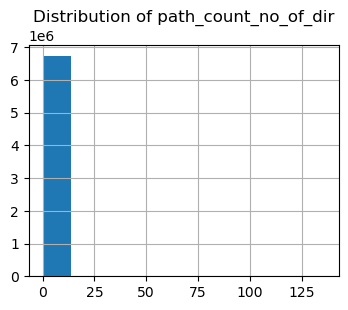

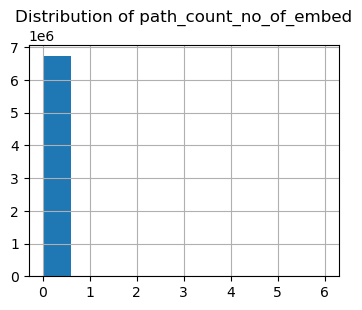

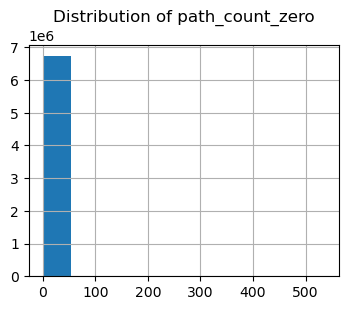

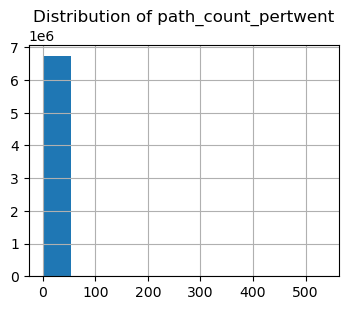

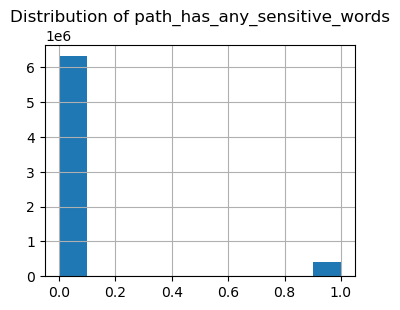

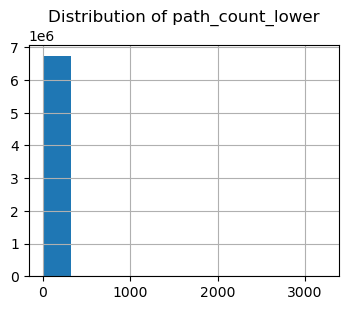

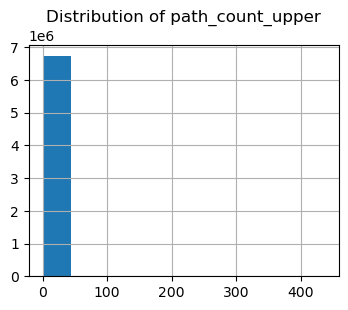

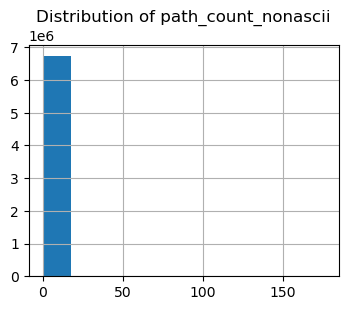

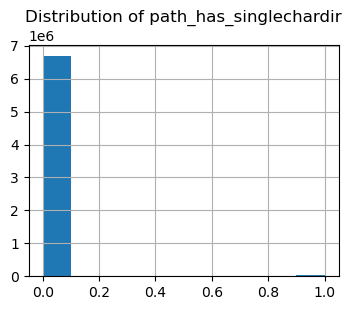

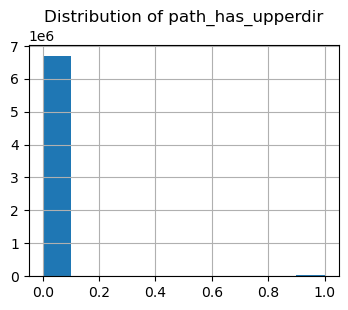

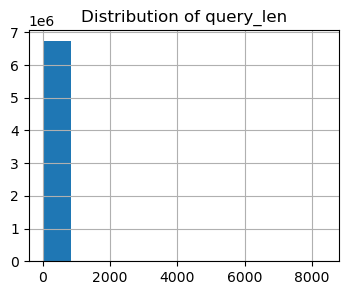

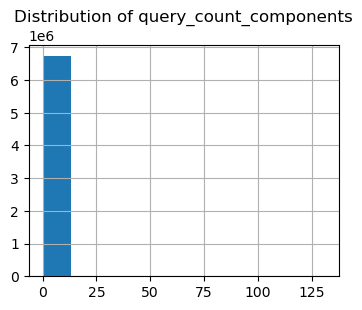

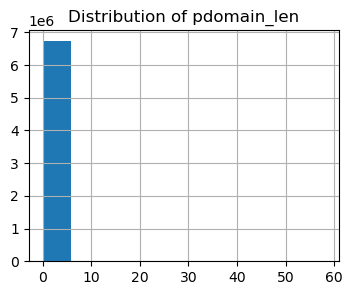

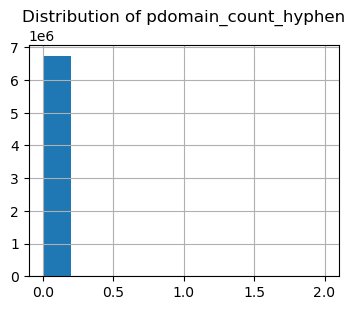

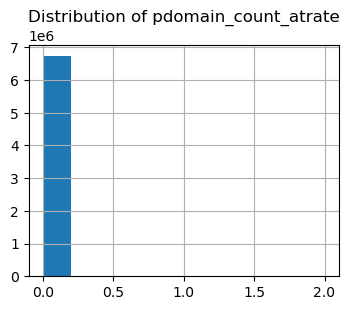

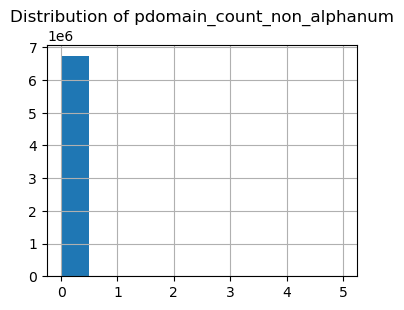

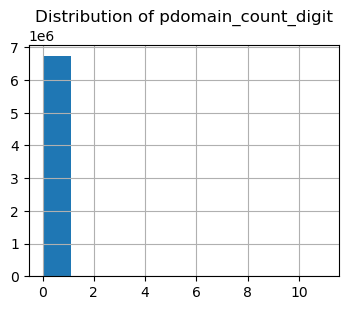

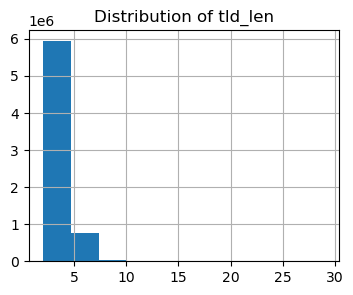

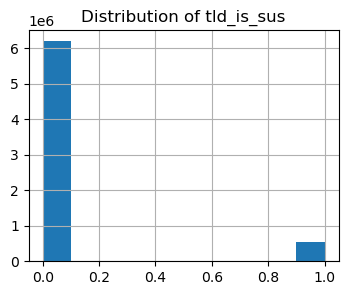

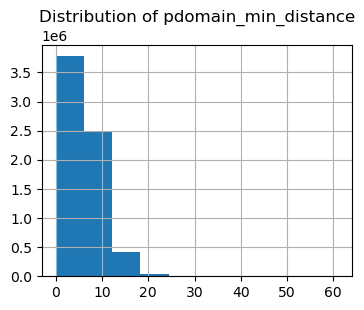

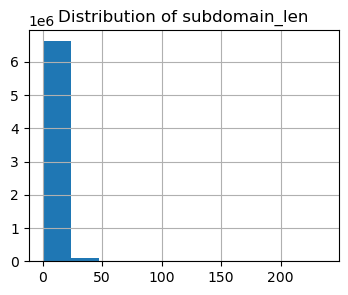

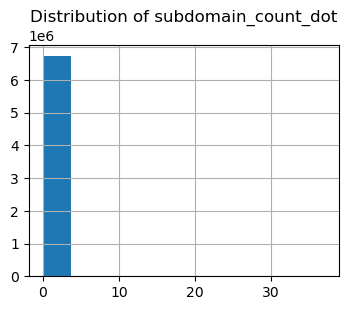

In [5]:
for column in url_data.columns:
    # Numerical features, plot a histogram
    if url_data[column].dtype != 'object':
        plt.figure(figsize=(4, 3))
        plt.hist(url_data[column])
        # url_data[column].plot(kind='box')
        plt.title(f'Distribution of {column}')
        plt.grid(True)
        plt.show()

#### Check for outliers.
Remove all records with at least one feature value being an outlier, based on a threshold. If a record has at least one feature with a value 2 IQRs below Q1 or above Q3, it is an outlier.

Because a lot of our plots show that the distribution of a lot of features are concentrated around a certain value, with some exceptions, we want the threshold to be high (increase from the standard 1.5 IQRs to 2 IQRs). If the threshold is too low, all records with values that slightly deviate from the mode will be classified as outliers.

We also replot to show how the distributions have changed. Note how the previous plots are skewed, with the plots showing the central bar (representing the value with the highest frequency) not being centered in the distribution. Removing outliers has fixed the skew.

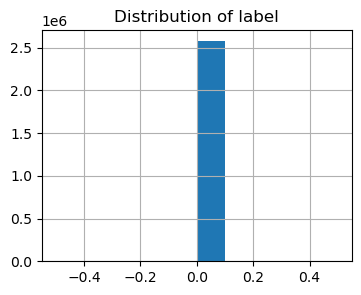

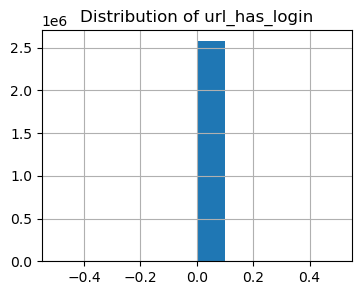

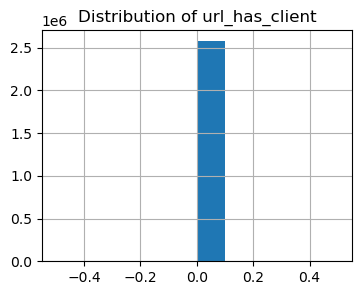

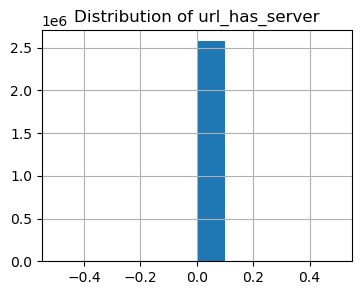

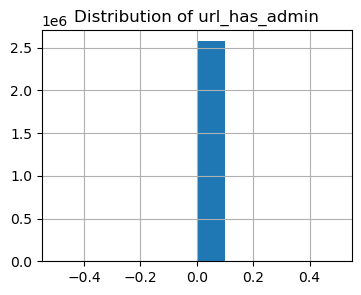

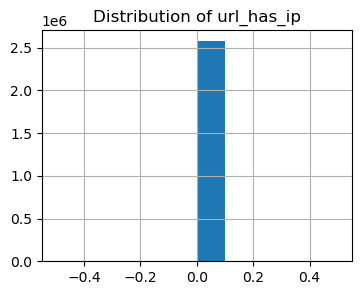

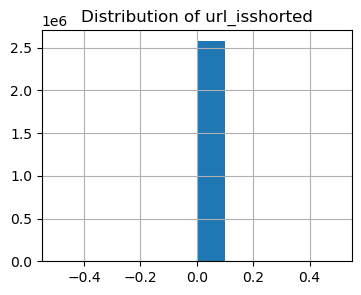

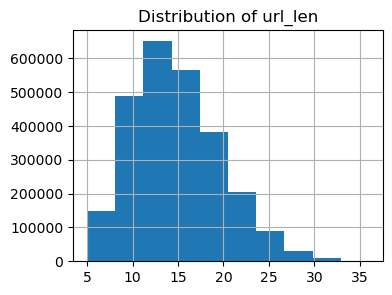

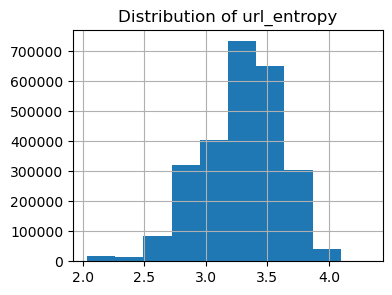

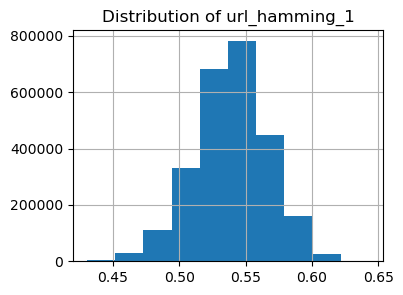

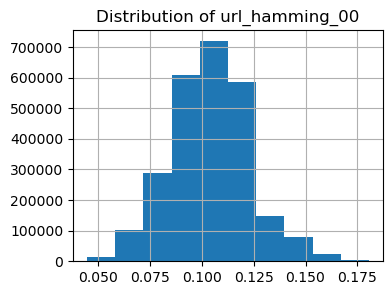

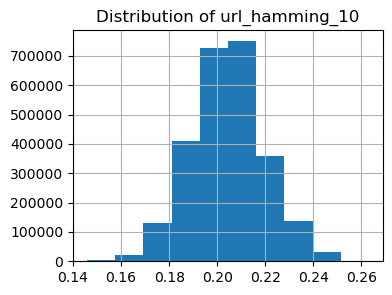

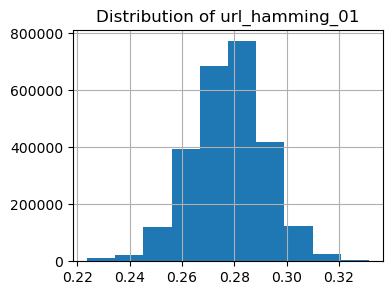

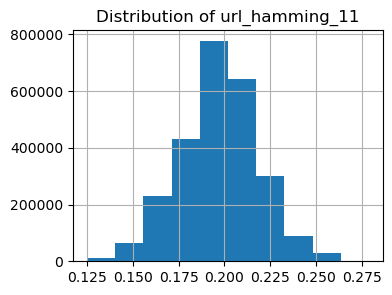

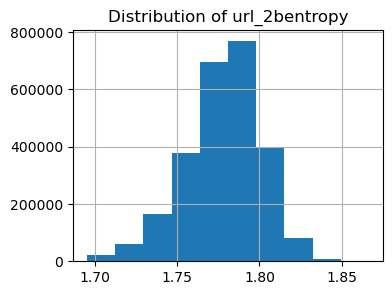

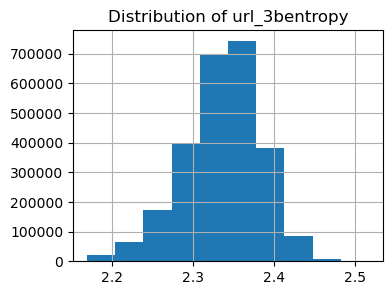

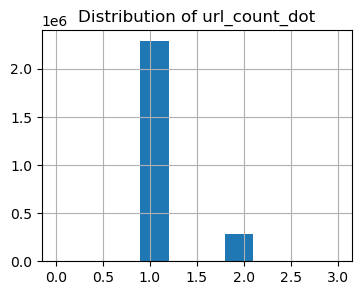

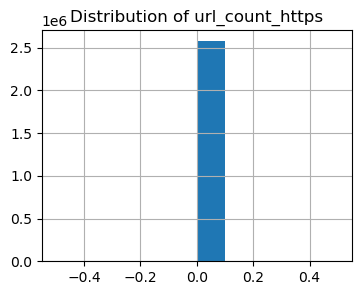

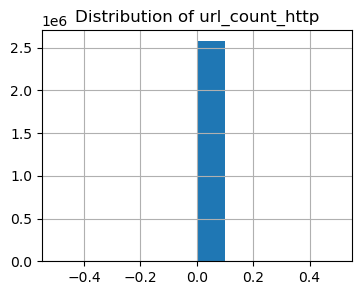

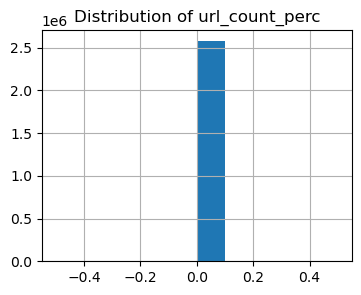

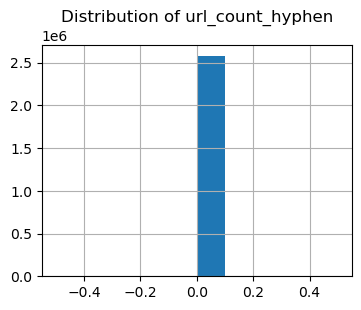

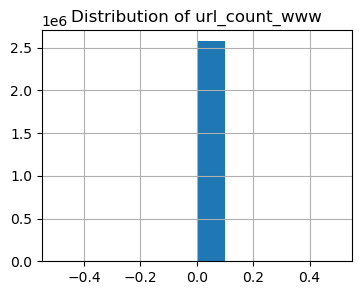

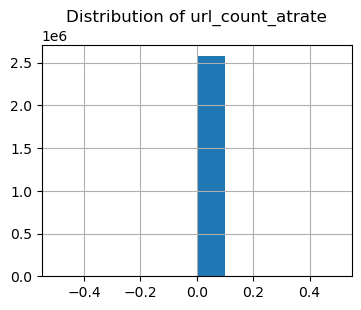

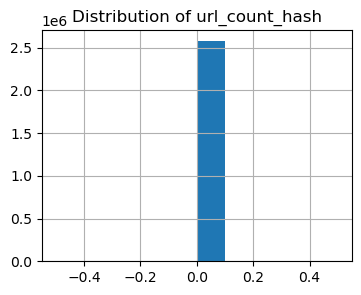

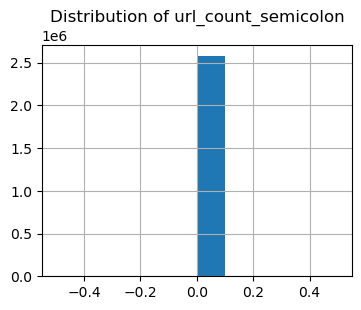

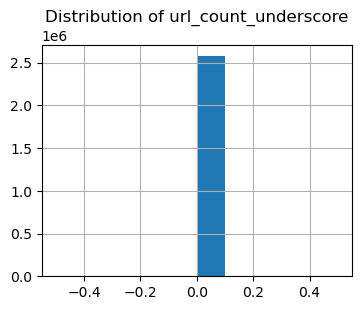

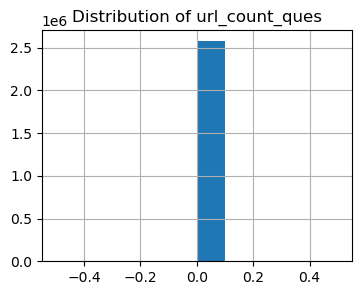

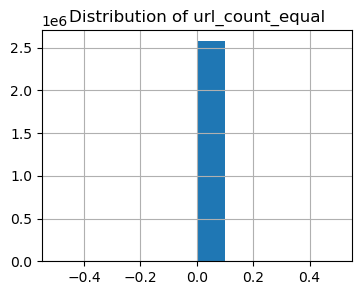

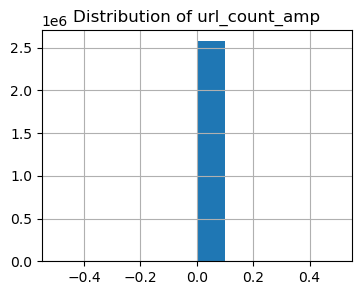

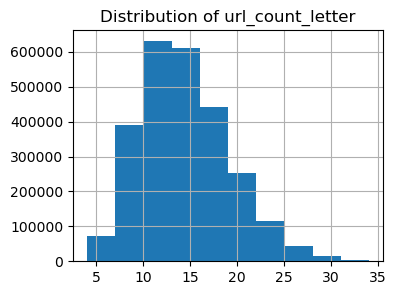

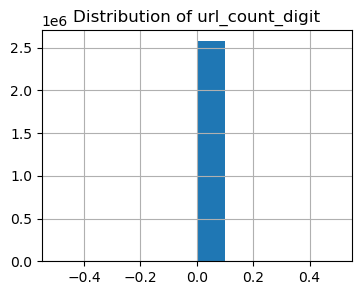

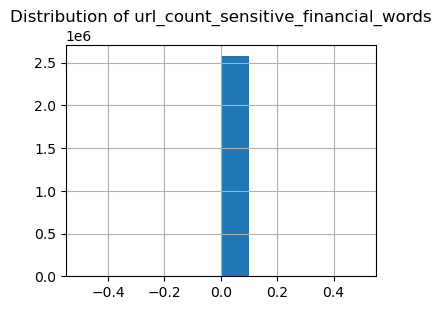

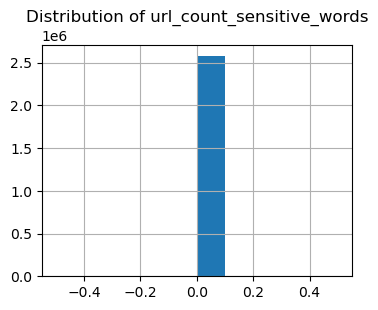

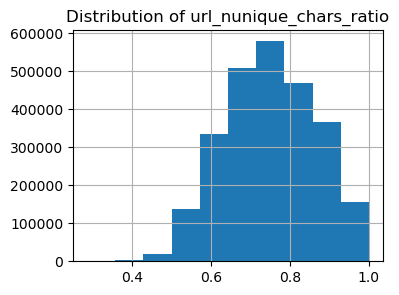

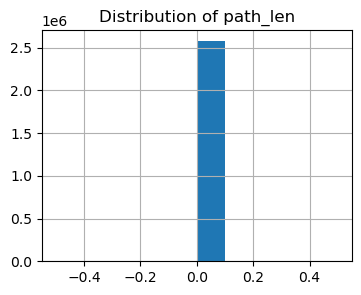

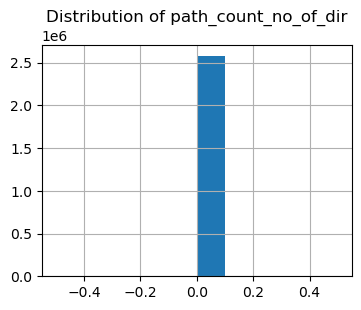

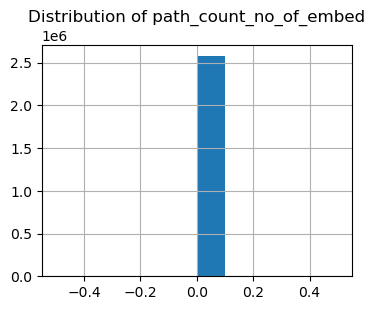

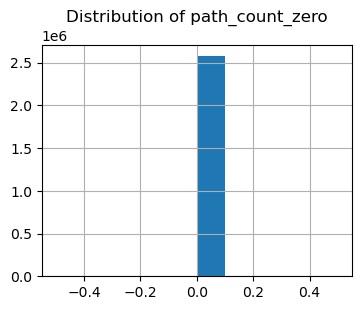

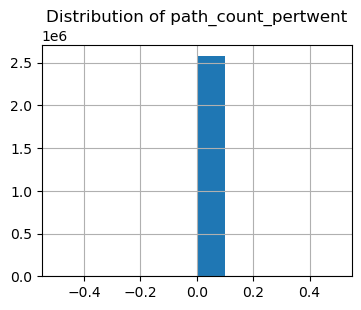

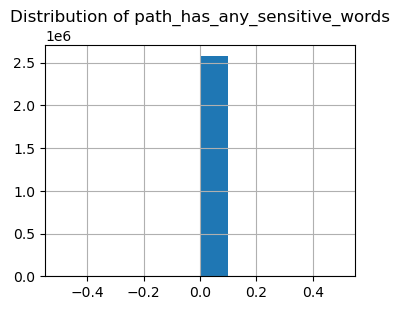

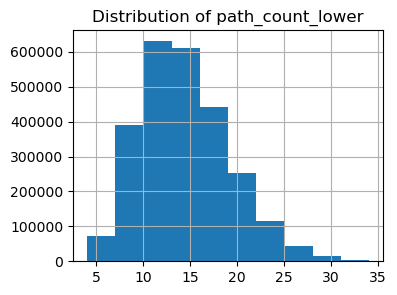

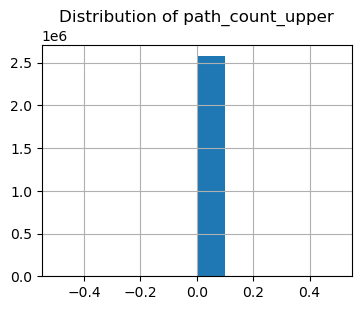

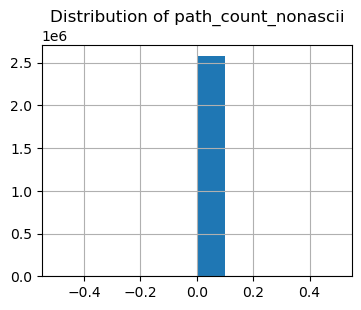

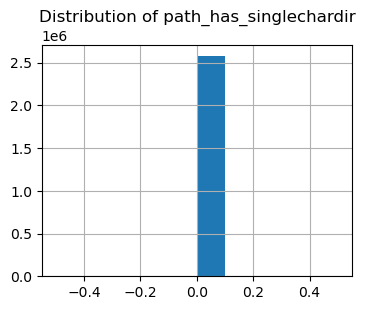

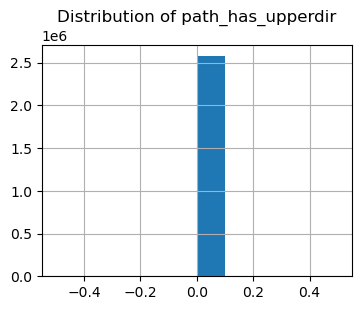

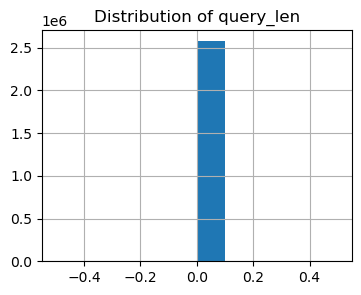

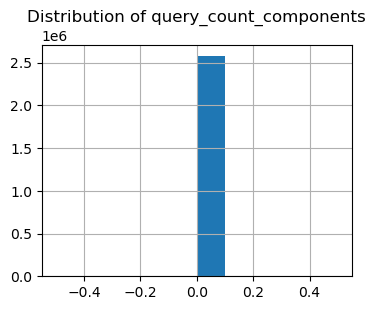

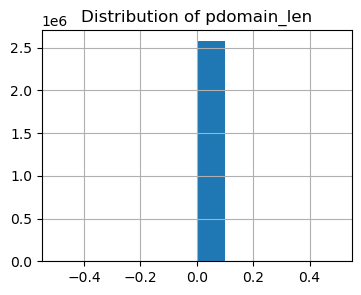

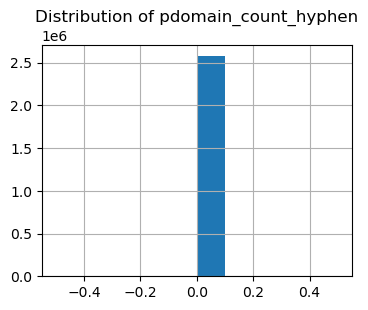

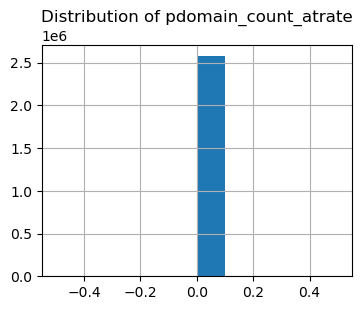

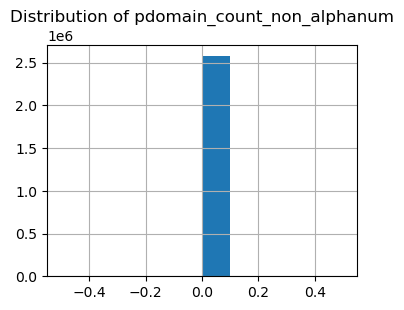

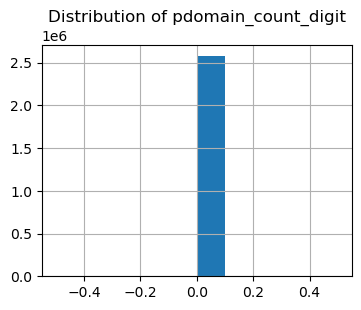

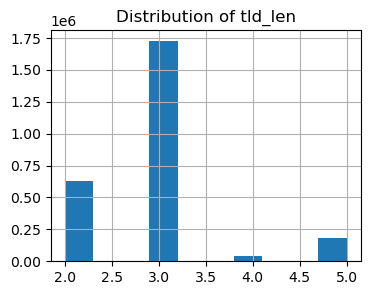

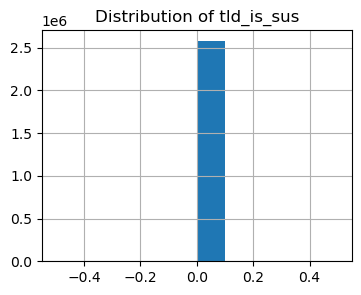

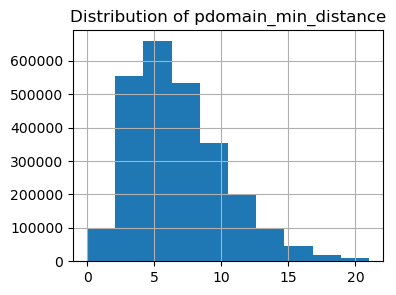

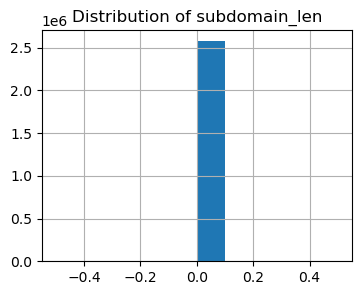

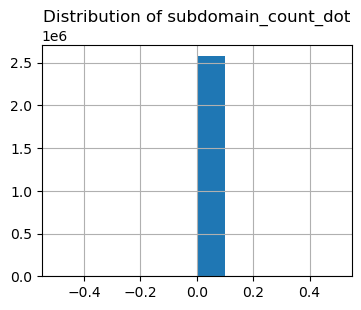

In [6]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 2.5 * IQR
    upper_bound = Q3 + 2.5 * IQR
    
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return df_cleaned

for column in url_data.columns:
    if url_data[column].dtype != 'object':
        url_data = remove_outliers_iqr(url_data, column)
        
for column in url_data.columns:
    # Numerical features, plot a histogram
    if url_data[column].dtype != 'object':
        plt.figure(figsize=(4, 3))
        plt.hist(url_data[column])
        # url_data[column].plot(kind='box')
        plt.title(f'Distribution of {column}')
        plt.grid(True)
        plt.show()

#### Select relevant features.
Because we have 60 features, it is necessary to select the relevant features to use in training. Below is a list of features we will use and the intuition behind its inclusion.

*url_len*: Length of the URL. Malicious URLs might be unusually long or short compared to legitimate ones.

*url_entropy*: Entropy of the URL. Higher entropy might indicate randomness, which could be a characteristic of obfuscated or malicious URLs.

*url_count_dot*: Number of dots in the URL. Excessive dots might indicate subdomains or directory traversals, common in malicious URLs.

*url_count_https* and *url_count_http*: Presence of "https" or "http" in the URL. Malicious URLs might use non-secure protocols or mimic secure ones.

*url_count_perc*: Count of percentage symbols in the URL. Used in URL encoding, which might be used to obfuscate malicious content.

*url_count_sensitive_words*: Count of sensitive words in the URL. Malicious URLs might contain keywords related to phishing, malware, or fraud.

*url_nunique_chars_ratio*: Ratio of unique characters in the URL. High uniqueness might indicate obfuscation or encoding.

*path_len*: Length of the path portion of the URL. Unusually long paths might be indicative of attempts to hide malicious content.

*path_count_no_of_dir*: Count of directories in the path. Complex directory structures might suggest obfuscation.

*path_has_any_sensitive_words*: Presence of sensitive words in the path. Malicious paths might contain keywords related to attacks.

*path_count_nonascii*: Count of non-ASCII characters in the path. Might indicate attempts to obfuscate using non-standard characters.

*pdomain_len*: Length of the parent domain. Unusually long or short domains might be indicative of malicious activity.

*pdomain_count_hyphen* and *pdomain_count_atrate*: Count of "-" and "@" symbols in the parent domain. Uncommon characters might be used in phishing URLs.

*tld*: Top-level domain. Some TLDs are more commonly associated with malicious activity.

*tld_is_sus*: Boolean indicating if the TLD is suspicious. Certain TLDs are commonly associated with malicious activity.

In [7]:
keep_features = ["url_len", "url_entropy", "url_count_dot", "url_count_https", "url_count_http", 
                 "url_count_perc", "url_count_sensitive_words", "url_nunique_chars_ratio", "path_len", 
                 "path_count_no_of_dir", "path_has_any_sensitive_words", "path_count_nonascii", 
                 "pdomain_len", "pdomain_count_hyphen", "pdomain_count_atrate", "tld", "tld_is_sus"]

url_data_train = url_data.loc[:, keep_features]

In [8]:
# NOTE: Y'all need to standardize and also oversample the minority class INSIDE of the cross validation loop